In [1]:
from gym import Env
import gym
import pygame
from gym.spaces import Discrete, Box,Dict
import numpy as np
import random
np.set_printoptions(linewidth=500,threshold=np.inf)

In [21]:
class AirTraffic():
    def __init__(self,planes:int = 2, grid_size:list = [5,5],radius:int = 2,seed = None):
        self.radius = radius
        self.planes = planes
        self.GRID_DIM = grid_size
        self.seed = seed
        self._max_dist = np.sqrt(self.GRID_DIM[0]**2 + self.GRID_DIM[1]**2)
        self._action_to_direction = {
            0: np.array([-1, 0]),
            1: np.array([-1, 1]),
            2: np.array([0,  1]),
            3: np.array([-1 , -1]),
            4: np.array([0 , -1]),
            
        }        
    
        self._ACTIONLOOKUP = {
            0: 'Up',
            1: 'front right',
            2: 'right',
            3: 'front left',
            4: 'left'
            }
        self.GRID_DIM = np.array(self.GRID_DIM)
        self.GRID = np.zeros(self.GRID_DIM)
        self.action_space = Discrete(len(self._ACTIONLOOKUP.keys()))
        self.state_space = Discrete(self.GRID_DIM[0]*self.GRID_DIM[1])
        self._ob_space = {}
        for p in range(self.planes):
            self._ob_space[f'plane{p}'] = Box(np.array([0,0]), np.array([self.GRID_DIM[0]-1,self.GRID_DIM[1] - 1]), shape=(2,), dtype=int)
            self._ob_space[f'dest{p}'] = Box(np.array([0,0]), np.array([self.GRID_DIM[0]-1,self.GRID_DIM[1] - 1]), shape=(2,), dtype=int)
        
        self.observation_space = Dict(self._ob_space)
        self._agent_location = []
        self._target_location = []
        if self.seed is not None:
            np.random.seed(seed = seed)
        for p in range(self.planes):
            while (pc:= [np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) in self._agent_location:
                continue
            self._agent_location.append(pc)
            while (dc:=[np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) in self._agent_location + self._target_location:
                continue
            self._target_location.append(dc)
        self._agent_location = np.array(self._agent_location)
        self._target_location = np.array(self._target_location)
        self._count = [0]*self.planes
        self._prev_agent_location = self._agent_location.copy()
        self._done_prev = [False]*self.planes
#         self._agent_location = np.array([np.array([np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) for p in range(self.planes) ])
#         self._target_location = np.array([np.array([np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) for p in range(self.planes)])
#         print(self._agent_location)
    def step(self,action):
#         self._prev_agent_location = [None]*self.planes
        self._prev_agent_location = self._agent_location.copy()##### Find the vector of agent from destination to find ### reward of terminal state for a plane is 0 and that plane cant move now
        moved_plane = [False]*self.planes

#             for plane,action in enumerate(action): 
        moved_plane = self._move(action)
        done,reward =  self._is_over()
        observation = self._get_obs()
        info = self._get_info()
        self._done_prev = done.copy()
        return observation, reward, done, info
    def _move(self, action):
        
        for plane,act in enumerate(action):
            if np.array_equal(self._agent_location[plane],self._target_location[plane]):
                self._count[plane]+=1
                continue
            elif np.sign(self._target_location[plane]-self._prev_agent_location[plane])[0]<=0:
                self._agent_location[plane] = np.clip(self._agent_location[plane] + self._action_to_direction[act],[0,0],[self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1])
            else: 
                self._agent_location[plane] = np.clip(self._agent_location[plane] + -1*self._action_to_direction[act],[0,0],[self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1])

        return   self._prev_agent_location== self._agent_location
    def _is_over(self):
        done = (self._agent_location==self._target_location).all(axis = 1)
        reward = self._get_reward()
        return done, reward
    def _get_reward(self):
        reward = []
        # reward will be the minimum of intruder and todestination
        distance, closest_dist ,_1,_2= self._get_info()
        for index,plane in enumerate(range(self.planes)):
            if self._count[plane] >0:
                reward.append(self._max_dist)######## CHanged from 0 
            elif closest_dist[plane] <self.radius:
                
#             closest_dist = np.min(np.linalg.norm([self._agent_location[plane]]*self.planes-self._agent_location,axis = 1))
                self._intruder = -(self.radius **2 - closest_dist[plane]**2)/(self.radius**2/500)
                reward.append(self._intruder)
#                 print(closest_dist[plane])
            else:
                self._todestination = self._max_dist - distance[plane]#np.linalg.norm(self._target_location[plane]-self._agent_location[plane])
                reward.append(self._todestination)
#             print(self._intruder,self._todestination)
#         print(reward)
#             reward.append(np.min([self._intruder,self._todestination]))
        return reward
    def _get_obs(self):
        return {'planes': self._agent_location,'destinations':self._target_location}
    def _get_info(self):
        closest_dist = []
        distance = []
#         arg_plane = []
        plane_theta = []
        plane_rho = []
        dne= self._done_prev
        for index,plane in enumerate(range(self.planes)):
            dist = np.linalg.norm([self._agent_location[plane]]*self.planes-self._agent_location,axis = 1)
#             if np.argmin(dist) == plane :
            dist[plane] = np.inf
            dist[dne] = np.inf
            closest_dist .append(np.min(dist))
            arg_plane = np.argmin(dist)
            if dne[arg_plane]:
                plane_rho.append(np.inf)
                plane_theta.append(np.inf)
            else:
                if (self._prev_agent_location==None).all():
                    self._prev_agent_location = self._agent_location.copy()
                ownship = self._agent_location[plane]-self._prev_agent_location[plane] 
                intruder = self._agent_location[arg_plane]-self._prev_agent_location[arg_plane]
                closest_path = self._agent_location[arg_plane]-self._agent_location[plane]
    #             deg = np.rad2deg(self.angle_between(intruder,ownship))
                y = np.array([intruder[1],ownship[1]])
                x = np.array([intruder[0],ownship[0]])
                degree = np.rad2deg(np.arctan2(y,x))
                deg = degree[1]-degree[0]
                alpha = np.rad2deg(np.arctan2(ownship[1],ownship[1]))
                beta =  np.rad2deg(np.arctan2(closest_path[1],closest_path[0]))
                deg_rho =  180 +(alpha-beta)
                plane_rho.append(deg_rho)
                plane_theta.append(180 + deg)
            distance .append(np.linalg.norm(self._target_location[plane]-self._agent_location[plane]))
    
#             print(self._intruder,self._todestination)
#         print(plane_theta,plane_rho)
#         print(degree)
        return distance,closest_dist,plane_theta,plane_rho





    def _state_to_index(self):
        _,closest_dist,plane_theta,plane_rho = self._get_info()
        dis_bin = np.arange(self.radius)
        angle_bins = np.arange(0,360,10)
        dist_index = np.digitize(closest_dist,dis_bin) -1
        theta_index = np.digitize(plane_theta,angle_bins) -1
        rho_index = np.digitize(plane_rho,angle_bins) -1
        return dist_index,theta_index,rho_index
            
    def _state_in_seq(self):
        seq = []
        for plane in self._agent_location:
            m, n = plane
            seq.append(m * self.GRID.shape[1] + n)
            
        return seq
    def render(self):
#         print(self._agent_location)
        rend = self.GRID.copy().astype(dtype = 'U2')
        for plane in range(self.planes):
            rend[self._agent_location[plane][0],self._agent_location[plane][1]] = f'p{plane}'
            rend[self._target_location[plane][0],self._target_location[plane][1]] = f'd{plane}'
#         rend[self._agent_location[:,0],np.array(self._agent_location)[:,1]] = 'p'
#         rend[np.array(self._target_location)[:,0],np.array(self._target_location)[:,1]] = 'd'
        return print(rend)
# if intruser dist < 50rew = intruder if >50 rew = distance dfrom dest 
    def reset(self):
        self._agent_location = []
        self._target_location = []
#         self.seed = seed
        if self.seed is not None:
#             self.seed = np.random.randint(5000)
            np.random.seed(seed = self.seed)
        for p in range(self.planes):
            while (pc:= [np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) in self._agent_location:
                continue
            self._agent_location.append(pc)
            while (dc:=[np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) in self._agent_location + self._target_location:
                continue
            self._target_location.append(dc)
        self._agent_location = np.array(self._agent_location)
        self._target_location = np.array(self._target_location)
        self._count = [0]*self.planes


In [280]:
env = AirTraffic(planes=3,grid_size=[100,100])
# env.render()

In [281]:
a = np.arange(0,380,10)
a

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370])

In [282]:
np.digitize(a,np.arange(0,360,10)) -1

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 35, 35], dtype=int64)

In [261]:
# env.reset()
# env.render()

In [262]:
env._state_to_index()

(array([36,  7,  7], dtype=int64),
 array([18, 18, 18], dtype=int64),
 array([35, 17, 35], dtype=int64))

In [247]:
env.step([0,0])

# env.render()

({'planes': array([[57, 37],
         [91,  4],
         [26, 40]]),
  'destinations': array([[36, 60],
         [31, 32],
         [91, 37]])},
 [110.27653323251464, 75.20957480832212, 76.35216229731975],
 array([False, False, False]),
 ([31.144823004794873, 66.2117814289874, 65.06919393998976],
  [31.144823004794873, 47.38143096192854, 31.144823004794873],
  [360.0, 180.0, 0.0],
  [5.527540151656154, 44.14490260373327, 185.52754015165618]))

In [248]:
env._state_to_index()

(array([31, 47, 31], dtype=int64),
 array([35, 18,  0], dtype=int64),
 array([ 0,  4, 18], dtype=int64))

In [235]:
env._get_info()

([0.0, 3.1622776601683795, 3.0],
 [2.23606797749979, 1.4142135623730951, 1.4142135623730951],
 [180.0, 180.0, 180.0],
 [26.565051177078004, 135.0, 315.0])

In [210]:
env._prev_agent_location

array([[0, 4],
       [2, 1],
       [4, 4]])

In [194]:
env._agent_location

array([[0, 0],
       [0, 4],
       [0, 1]])

In [195]:
env.step([4,0])
env.render()

[0.0, 0.0, 0.0] [-90.0, 90.0, 90.0]
[0.0, 0.0, 0.0] [-90.0, 90.0, 90.0]
[['d1' 'p2' '0.' 'd0' 'p1']
 ['0.' '0.' '0.' 'd2' '0.']
 ['0.' '0.' '0.' '0.' '0.']
 ['0.' '0.' '0.' '0.' '0.']
 ['0.' '0.' '0.' '0.' '0.']]


In [196]:
env.step([4,4])
env.render()

[0.0, -90.0, 0.0] [-90.0, -45.0, 90.0]
[0.0, -90.0, 0.0] [-90.0, -45.0, 90.0]
[['d1' 'p2' '0.' 'p1' '0.']
 ['0.' '0.' '0.' 'd2' '0.']
 ['0.' '0.' '0.' '0.' '0.']
 ['0.' '0.' '0.' '0.' '0.']
 ['0.' '0.' '0.' '0.' '0.']]


In [8]:
env.step([3,3])
env.render()

[96.394448724536, 99.0]
[['0.' '0.' 'p1' 'd0' '0.']
 ['0.' '0.' 'd1' '0.' '0.']
 ['p0' '0.' '0.' '0.' '0.']
 ['0.' '0.' '0.' '0.' '0.']
 ['0.' '0.' '0.' '0.' '0.']]


In [9]:
env.step([3,3])
env.render()

[96.83772233983161, 99.0]
[['0.' '0.' '0.' 'd0' '0.']
 ['p0' '0.' 'd1' 'p1' '0.']
 ['0.' '0.' '0.' '0.' '0.']
 ['0.' '0.' '0.' '0.' '0.']
 ['0.' '0.' '0.' '0.' '0.']]


In [10]:
np.inf- 5

inf

In [11]:
a = [[1,1],[2,2],[3,6]]
b = np.array([[2,3],[2,5],[2,6]])
np.min(np.linalg.norm(a-b,axis=1))

1.0

In [12]:
c = np.zeros([8,8])
c[b[:,0],b[:,1]] = 1
c

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [13]:
x = [np.array([np.random.randint(4),np.random.randint(5)]) for p in range(2)]
x
y = [np.array([np.random.randint(4),np.random.randint(5)]) for p in range(2)]
y

[array([0, 4]), array([0, 2])]

In [14]:
x+y

[array([2, 1]), array([2, 4]), array([0, 4]), array([0, 2])]

In [15]:
y = np.array(y)
x = np.array(x)
y[0]

array([0, 4])

In [16]:
x

array([[2, 1],
       [2, 4]])

In [118]:
env = AirTraffic()
env._state_in_seq()
n_planes,n_states, n_actions = env.planes, env.state_space.n, env.action_space.n
Q = np.zeros((n_planes, n_states, n_actions))
seq = env._state_in_seq()

for plane,s in enumerate(seq):
    Q[plane,s,:] = 1
    print(seq)
    print((Q[plane,s,:]!=0).all(axis = 0))

[19, 15]
True
[19, 15]
True


In [3]:
from IPython.display import clear_output

In [10]:
env = AirTraffic()

def ep_greedy(env,Q,epsilon=0.9):
    dist_index,theta_index,rho_index = env._state_to_index()
#     print(dist_index)
#     print(seqs)
    action = []
    for plane in range(env.planes):
        if np.random.random()<epsilon:
    #         print(Q[seq,:])

            x=(Q[dist_index[plane],theta_index[plane],rho_index[plane],:]!=0).all()
    #         print(x,'here')
            if x :           
                action.append(np.argmax(Q[dist_index[plane],theta_index[plane],rho_index[plane],:]))
    #             print('h')
            else:
                axn = np.where(Q[dist_index[plane],theta_index[plane],rho_index[plane],:]==0)[0]
    #             print(action)
                action.append(axn[0])
    #             print('why')
        else:
            action.append(np.random.randint(env.action_space.n))
    #     print(action)
    return action
def Sarsa(env,alpha, gamma, epsilon, episodes, max_steps):
    timestep_reward = []
    cumsum_reward  = []
    count_st = np.zeros((env.planes, env.state_space.n, env.action_space.n))
    for ep in range(episodes):
        env.reset()
        done = [False]*env.planes
        total_reward = [0]*env.planes
        cumsum_ep= []
        curr_dist_index,curr_theta_index,curr_rho_index = env._state_to_index()
        curr_a = ep_greedy(env,Q)
        t = 0
        while not np.array(done).all() :
            obs, reward, done, info = env.step(curr_a)
            nxt_dist_id,nxt_theta_id,nxt_rho_id = env._state_to_index()
            total_reward= np.add(total_reward,reward)
            next_act = ep_greedy(env,Q)
    #         s = curr_state 
    #         s_ = next_state 
    #         a_ = next_act
            t+=1
            for plane in range(env.planes):
                Q[curr_dist_index[plane],curr_theta_index[plane],curr_rho_index[plane],curr_a[plane]] += alpha * ( reward[plane] + (gamma * Q[nxt_dist_id[plane],nxt_theta_id[plane],nxt_rho_id[plane], next_act[plane]] ) 
                                                                                                   - Q[curr_dist_index[plane],curr_theta_index[plane],curr_rho_index[plane],curr_a[plane]] )
            curr_dist_index,curr_theta_index,curr_rho_index = nxt_dist_id,nxt_theta_id,nxt_rho_id
            curr_a = next_act
    #         print(reward)
#             env.render()
#         print(t)
#             cumsum_ep.append(total_reward/(t))
            print(t,ep,end=' ')
            clear_output(wait=True)        
        cumsum_reward.append(total_reward/t)
        timestep_reward.append(total_reward)
    return timestep_reward,cumsum_reward

In [288]:
18 + np.arange(-18,18,1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

In [289]:
ep_greedy(env,Q*1)

[1 1]


[0, 0]

In [290]:
Q.shape

(2, 36, 36, 5)

In [291]:
env.step([1,1,1])

IndexError: index 2 is out of bounds for axis 0 with size 2

In [11]:
env = AirTraffic(planes=5,grid_size=[10,10],radius=5)
n_radius,n_theta, n_rho,n_actions = env.radius, 36,36, env.action_space.n
Q = np.zeros((n_radius, n_theta,n_rho, n_actions))
env.render()
alpha = 0.4
gamma = 0.9
epsilon = 0.9
episodes = 50
max_steps = 1e4
# n_tests = 20
timestep_reward,cumsum_reward = Sarsa(env,alpha, gamma, epsilon, episodes, max_steps)
# print(timestep_reward)

116 49 

In [12]:
env.render() # if the plane is already done then that plane has inf dist to other  planes, angle is also inf. if only one plane exists 

[['0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.']
 ['0.' '0.' '0.' '0.' 'd4' '0.' '0.' '0.' '0.' '0.']
 ['0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.' 'd2']
 ['0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.']
 ['0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.']
 ['d1' '0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.']
 ['0.' 'd3' '0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.']
 ['0.' 'd0' '0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.']
 ['0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.']
 ['0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.' '0.']]


In [13]:
env._get_info()

([0.0, 0.0, 0.0, 0.0, 0.0],
 [inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf],
 [inf, inf, inf, inf, inf])

In [14]:
env._state_to_index()

(array([4, 4, 4, 4, 4], dtype=int64),
 array([35, 35, 35, 35, 35], dtype=int64),
 array([35, 35, 35, 35, 35], dtype=int64))

In [ ]:
Q.shape

In [ ]:
env.render()

In [ ]:
env._get_obs()

In [155]:
env.reset()
env._get_obs()
print(env.render())

[['0.' 'd0' '0.' '0.' '0.']
 ['0.' '0.' 'p2' '0.' '0.']
 ['0.' '0.' '0.' '0.' '0.']
 ['p1' '0.' '0.' '0.' 'p0']
 ['0.' '0.' 'd2' '0.' 'd1']]
None


In [194]:
# timestep_reward

In [196]:
# cumsum_reward

In [15]:
cumsum_rew  = np.cumsum(timestep_reward,axis=0)
cumsum_rew
cumsum_plain_avg = np.average(cumsum_reward,axis=1)
# cumsum_ep_avg.shape
# np.ma.average(cumsum_reward,axis=2)
# np.average(cumsum_rew,axis=1)

In [159]:
timestep_reward
import pandas as pd
rewx = []
print(rewx)
for plane in range(len(timestep_reward[0])):
    rew = []
    for episode in timestep_reward:
        rew.append(episode[plane])
    rewx.append(rew)
#     print(rewards)
# rewards
# len(timestep_reward[0])
# a = rewx[0]
# a.append(1)
# rewx


[]


In [160]:
np.average(cumsum_reward,axis=1)

array([-4.02571043, -7.821517  , -3.31214357, -3.03295029, -1.39928223, -3.01174425, -7.24045566, -5.00987255, -2.99111931, -3.52854292, -3.00961612, -2.85918106, -3.2091897 , -3.08125563, -3.05560023, -3.16839148, -2.63532234, -3.37022954, -2.6401684 , -3.22018028, -3.16575462, -3.03269595, -2.72145744, -2.48782918, -3.33797239, -3.12585802, -2.99980843, -2.91395761, -2.94273244, -3.05994582, -2.94273244, -3.07118446, -3.24679526, -2.8968569 , -2.82369919, -2.48782918, -2.75089798,
       -2.91399971, -2.97103185, -3.18785961, -2.8968569 , -2.82369919, -2.48782918, -2.48782918, -3.17698817, -3.07118446, -3.24679526, -2.8968569 , -2.82369919, -2.48782918])

Text(0, 0.5, 'Average Score')

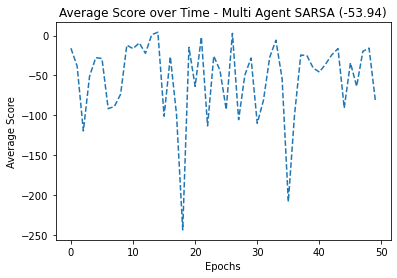

In [19]:
import matplotlib.pyplot as plt
# plt.plot(timestep_reward)
# plt.plot(rewx)
# plt.plot(cumsum_rew)
# plt.plot(cumsum_avg,'r')
# plt.plot(cumsum_reward)
# plt.title(label=f'Average Score over Time')
plt.title(label=f'Average Score over Time - Multi Agent SARSA ({np.average(cumsum_plain_avg) :.2f})')
plt.plot(cumsum_plain_avg,linestyle ='--')
plt.xlabel('Epochs')
plt.ylabel(f'Average Score')
# plt.legend()

In [20]:
50-np.inf

-inf

In [149]:
# np.average(cumsum_plain_avg)

#### Random agent

must follow greedy until any plane close

In [114]:
def random_pol(env,episodes):
    action_space ={
        0: np.array([-1, 0]),
        1: np.array([-1, 1]),
        2: np.array([0,  1]),
        3: np.array([-1 , -1]),
        4: np.array([0 , -1]),            
    }
    timestep_reward = []
    cumsum_reward  = []
    max_step=100
    for ep in range(episodes):
        env.reset()
#         print(env._get_obs())
        done =  [False]*env.planes
        total_reward = [0]*env.planes
        cumsum_ep= []
        t=0
        while not np.array(done).all() and t<max_step:
            
            action = []
            distance, closest_dist = env._get_info()
            for plane in range(env.planes):
                if closest_dist[plane]< env.radius:
                    action.append(np.random.randint(env.action_space.n))
                else:
                    x = np.sign(env._target_location[plane] - env._agent_location[plane])
                    if x[0] in [0,-1]:
                        for act,a in enumerate(action_space.values()):
                            _ = np.array_equal(x,a)
                            if _:
#                                 print(_)
                                action.append(act)
                                break
                    else:
                        x = -x
                        for act,a in enumerate(action_space.values()):
                            _ = np.array_equal(x,a)
                            if _:
                                action.append(act)
                                break
            t+=1
            obs,reward,done,info  = env.step(action)
            total_reward= np.add(total_reward,reward)
#             print(t)
#         print(ep)
#             env.render()
#         print('___________')
        cumsum_reward.append(total_reward/t)
        timestep_reward.append(total_reward)
            
    return timestep_reward,cumsum_reward            

In [122]:
env = AirTraffic(planes=3)
episodes = 500
timestep_reward,cumsum_reward = random_pol(env,episodes)

In [123]:
cumsum_rew  = np.cumsum(timestep_reward,axis=0)
cumsum_rew
cumsum_plain_avg = np.average(cumsum_reward,axis=1)

Text(0, 0.5, 'Average Score')

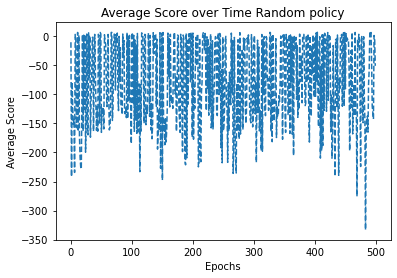

In [124]:
import matplotlib.pyplot as plt
plt.title(label=f'Average Score over Time Random policy')
plt.plot(cumsum_plain_avg,linestyle ='--')
plt.xlabel('Epochs')
plt.ylabel(f'Average Score')
# plt.legend()

## Greedy Agent

In [125]:
def greedy_pol(env,episodes):
    action_space ={
        0: np.array([-1, 0]),
        1: np.array([-1, 1]),
        2: np.array([0,  1]),
        3: np.array([-1 , -1]),
        4: np.array([0 , -1]),            
    }
    timestep_reward = []
    cumsum_reward  = []
    max_step=100
    for ep in range(episodes):
        env.reset()
#         print(env._get_obs())
        done =  [False]*env.planes
        total_reward = [0]*env.planes
        cumsum_ep= []
        t=0
        while not np.array(done).all() and t<max_step:
            
            action = []
            x = np.sign(env._target_location[plane] - env._agent_location[plane])
            if x[0] in [0,-1]:
                for act,a in enumerate(action_space.values()):
                    _ = np.array_equal(x,a)
                    if _:
#                                 print(_)
                        action.append(act)
                        break
            else:
                x = -x
                for act,a in enumerate(action_space.values()):
                    _ = np.array_equal(x,a)
                    if _:
                        action.append(act)
                        break
            t+=1
            obs,reward,done,info  = env.step(action)
            total_reward= np.add(total_reward,reward)
#             print(t)
#         print(ep)
#             env.render()
#         print('___________')
        cumsum_reward.append(total_reward/t)
        timestep_reward.append(total_reward)
            
    return timestep_reward,cumsum_reward            

In [138]:
env = AirTraffic(planes=3)
episodes = 200
timestep_reward,cumsum_reward = random_pol(env,episodes)

In [139]:
cumsum_plain_avg = np.average(cumsum_reward,axis=1)

Text(0, 0.5, 'Average Score')

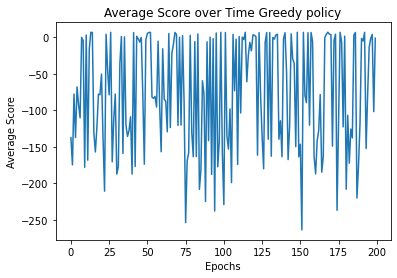

In [ ]:
import matplotlib.pyplot as plt
plt.title(label=f'Average Score over Time Greedy policy')
plt.plot(cumsum_plain_avg)
plt.xlabel('Epochs')
plt.ylabel(f'Average Score')
# plt.legend()

In [2]:
import numpy as np

In [22]:
a = np.zeros([3,5,4])
ax = [1,2,3]
for plane, seq in enumerate( [0,1,4]): 
    a[plane,seq,ax[plane]]+=1

In [23]:
a

array([[[0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 1.]]])

In [30]:
b = np.zeros([3,5,4])
ax = [1,2,3]
c = [0,1,4]
# for plane, seq in enumerate( [0,1,4]): 
b[plane,seq,ax[plane]]+=1 for plane, in c
b

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices